# Limit order book (LOB) simulation

Using [Bouchaud et al. (2018)](https://doi.org/10.1017/9781316659335) as the main reference here.

The simulation of financial markets through the use of agent-based models is an increasingly popular technique to understand the microstructure of their dynamics from the bottom up. In this notebook, we'll look at an example market simulation.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get the class structures
import sys
sys.path.append("/Users/Rob/work/finmarbs/utils/")
from lobsim import LOBsim
from sfagent import SFagentens

Begin with an **individual-agent** version of the original **Santa Fe model** using a synchronous ensemble rejection algorithm. The key point here is to make sure the overall holding rate is large enough which should limit the number of anachronisms in the order flow...

In [4]:
setup = {
    # Number of agents
    "Nagents" : 100,
    # Limit order rate per agent
    "LOrateperagent" : 10.0,
    # Market order rate per agent
    "MOrateperagent" : 0.5,
    # Cancel order rate per agent
    "COrateperagent" : 0.1,
    # Limit order bid ratio
    "LObidratio" : 0.45,
    # Market order bid ratio
    "MObidratio" : 0.45,
    # Cancel order bid ratio
    "CObidratio" : 0.45,
    # The overall holding rate
    "HOrate" : 50.0,
    # Limit order decay power in price units
    "LOdecay" : 0.05,
    # Initial bid tick
    "initbidpricetick" : 50,
    # Initial ask tick
    "initaskpricetick" : 51,
    # The price tick size
    "tickscale" : 1.0,
    # The number of price points simulated
    "Nlattice" : 100,
}

# Initialise the LOB simulation
los = LOBsim(setup, agentens=SFagentens)

# Iterate the LOB over time
tend, t = 100.0, 0.0
midps = []
while t < tend:
    los.iterate()
    t = los.time
    midps.append([t, los.market_state_info["midprice"]])

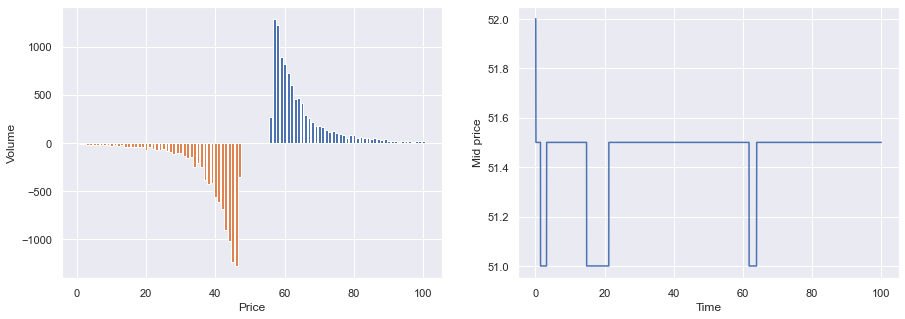

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(los.prices, los.asks)
ax[0].bar(los.prices, -los.bids)
ax[1].plot(np.asarray(midps)[:, 0], np.asarray(midps)[:, 1])
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
ax[1].set_ylabel('Mid price')
ax[1].set_xlabel('Time')
plt.show()

The master equation for the process above at price $p$ is

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t) &= \frac{1}{2}\sum_{\forall i}r^{\lambda}_{ib}\lambda_i[m(t)-p] P(\dots, V^p_{ib}-1, \dots, V^p_{ia}, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}(1-r^{\lambda}_{ib})\lambda_i[p-m(t)] P(\dots, V^p_{ib}, \dots, V^p_{ia}-1, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}\frac{(V^p_{ib}+1)\sum_{\forall i'}r^{\mu}_{i'b}\mu_{i'}[p-b(t)]}{V^p_{ib}+1+\sum_{\forall i'\neq i}V^p_{i'b}} P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}\frac{(V^p_{ia}+1)\sum_{\forall i'}(1-r^{\mu}_{i'b})\mu_{i'}[p-a(t)]}{V^p_{ia}+1+\sum_{\forall i'\neq i}V^p_{i'a}} P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}(V^p_{ib}+1)r^{\nu}_{ib}\nu_i P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}(V^p_{ia}+1)(1-r^{\nu}_{ib}) \nu_i P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&- \frac{1}{2}\sum_{\forall i}
\bigg\{ r^{\lambda}_{ib}\lambda_i[m(t)-p] + (1-r^{\lambda}_{ib})\lambda_i[p-m(t)] + r^{\mu}_{ib}\mu_i[p-b(t)] \\
& \qquad \qquad + (1-r^{\mu}_{ib})\mu_i[p-a(t)] + r^{\nu}_{ib}\nu_i V^p_{ib} + (1-r^{\nu}_{ib})\nu_iV^p_{ia} \bigg\} P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t)\,,
\end{align}
$$

where $m(t)=[b(t)+a(t)]/2$ is the mid price and the other functions are

$$
\begin{equation}
\lambda_i(x) = \lambda_ie^{-\alpha x}\mathbb{1}_{x>0}\,, \quad \mu_i(x) = \mu_i\mathbb{1}_{x=0}\,,
\end{equation}
$$

where $\lambda_i$ is a limit order rate, $r^{\lambda}_{ib}$ is the limit order bid ratio, $\mu_i$ is a market order rate, $r^{\mu}_{ib}$ is the market order bid ratio, $\nu_i$ is an order-cancellation rate and $r^{\nu}_{ib}$ is the order-cancellation bid ratio for the $i$-th agent. Note that we denote $\mathbb{1}_A$ as an indicator function which takes value unity when $A$ is true, else 0.

Let us now approximate the terms $V^p_{ia}+1+\sum_{\forall i'\neq i}V^p_{i'a}$ and $V^p_{ib}+1+\sum_{\forall i'\neq i}V^p_{i'b}$ in the denominator of the market order rate coefficients for the $i$-th agent to be the time-dependent processes $F^p_{a}(t)$ and $F^p_{b}(t)$ which are uncorrelated to the $i$-th agent's actions. By then marginalising over the full master equation bid and ask volumes $\forall i'\neq i$, we can hence obtain an approximate equation for each individual agent

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(V^p_{ib}, V^p_{ia}, t) &\simeq \frac{1}{2}r^{\lambda}_{ib}\lambda_i[m(t)-p] P(V^p_{ib}-1, V^p_{ia}, t) + \frac{1}{2}(1-r^{\lambda}_{ib})\lambda_i[p-m(t)] P(V^p_{ib}, V^p_{ia}-1, t) \\
&+ \sum_{\forall i'}r^{\mu}_{i'b}\mu_{i'}[p-b(t)] \frac{(V^p_{ib}+1)}{2F^p_{b}(t)}P(V^p_{ib}+1, V^p_{ia}, t) + \sum_{\forall i'}(1-r^{\mu}_{i'b})\mu_{i'}[p-a(t)] \frac{(V^p_{ia}+1)}{2F^p_{a}(t)}P(V^p_{ib}, V^p_{ia}+1, t) \\
&+ \frac{1}{2}(V^p_{ib}+1)r^{\nu}_{ib}\nu_i P(V^p_{ib}+1, V^p_{ia}, t) + \frac{1}{2}(V^p_{ia}+1) (1-r^{\nu}_{ib})\nu_i P(V^p_{ib}, V^p_{ia}+1, t) \\
&- \frac{1}{2}
\bigg\{ r^{\lambda}_{ib}\lambda_i[m(t)-p] + (1-r^{\lambda}_{ib})\lambda_i[p-m(t)] + \sum_{\forall i'}r^{\mu}_{i'b}\mu_{i'}[p-b(t)] \frac{V^p_{ib}}{2F^p_{b}(t)} \\
& \qquad \qquad + \sum_{\forall i'}(1-r^{\mu}_{i'b})\mu_{i'}[p-a(t)] \frac{V^p_{ia}}{2F^p_{a}(t)} + r^{\nu}_{ib}\nu_i V^p_{ib} + (1-r^{\nu}_{ib})\nu_iV^p_{ia} \bigg\} P(V^p_{ib}, V^p_{ia}, t)\,.
\end{align}
$$

Taking the first moments of this equation with respect to $V^p_a$ and $V^p_b$ in turn, we then obtain the probability mass function solution of two independent time-inhomogeneous Poisson processes

$$
\begin{align}
P(V^p_{ib}, V^p_{ia}, t) &\simeq {\rm Poisson}\big[ V^p_{ib};{\rm E}_{t}(V^p_{ib})\big] {\rm Poisson}\big[ V^p_{ia};{\rm E}_{t}(V^p_{ia})\big]\\
{\rm E}_{t}(V^p_{ib}) &\simeq {\rm E}_{t_0}(V^p_{ib})\exp \bigg\{ - \int_{t_0}^t \frac{\sum_{\forall i'}r^{\mu}_{i'b}\mu_{i'}[p-b(t')]}{2F^p_{b}(t')}{\rm d}t' - \frac{1}{2}r^{\nu}_{ib}\nu_i(t-t_0)\bigg\} \\
&+  \frac{1}{2}\int_{t_0}^t {\rm d}t' r^{\lambda}_{ib}\lambda_i[m(t')-p] \exp \bigg\{ - \int_{t'}^t \frac{\sum_{\forall i'}r^{\mu}_{i'b}\mu_{i'}[p-b(t'')]}{2F^p_{b}(t'')}{\rm d}t'' - \frac{1}{2}r^{\nu}_{ib}\nu_i(t-t')\bigg\} \\
{\rm E}_{t}(V^p_{ia}) &\simeq {\rm E}_{t_0}(V^p_{ia})\exp \bigg\{ - \int_{t_0}^t\frac{\sum_{\forall i'}(1-r^{\mu}_{i'b})\mu_{i'}[p-a(t')]}{2F^p_{a}(t')}{\rm d}t' - \frac{1}{2}(1-r^{\nu}_{i'b})\nu_i(t-t_0)\bigg\} \\
&+ \frac{1}{2}\int_{t_0}^t{\rm d}t'(1-r^{\lambda}_{ib})\lambda_i[p-m(t')]\exp \bigg\{ - \int_{t'}^t\frac{\sum_{\forall i'}(1-r^{\mu}_{i'b})\mu_{i'}[p-a(t'')]}{2F^p_{a}(t'')}{\rm d}t'' - \frac{1}{2}(1-r^{\nu}_{i'b})\nu_i(t-t')\bigg\} \,.
\end{align}
$$

Note that by summing over $i$, we obtain an approximate description of the volume queue at each price $p$. Furthermore, we may infer that the probabilities for a price having non-zero bid or ask volume, respectively, at time $t$ are given by

$$
\begin{equation}
P(V^p_{b}>0, t) = 1-e^{-\sum_{\forall i}{\rm E}_{t}(V^p_{ib})}\,, \qquad P(V^p_{a}>0, t) = 1-e^{-\sum_{\forall i}{\rm E}_{t}(V^p_{ia})}\,.
\end{equation}
$$

Model improvements/extensions to consider:
1. Self-exciting processes to deal with endogeneous effects, like event clustering.
2. Available-volume-dependent market order rates, e.g., $\mu_i=\mu_i[p-b(t),V^b_{ib}]$.
3. Relative probabilities of ask/bid market orders depends on the available volume imbalance, i.e., $r_{ib} \rightarrow \frac{r_{ib}+\sum_{\forall i'}V^b_{i'b}}{1+\sum_{\forall i'}(V^b_{i'b} + V^a_{i'a})}$.
4. Order flows that are **not** independent from one-another. E.g., include the long-range autocorrelation of market order signs. Also, market orders tend to be followed by limit orders which restore the depleted queue.
5. Cleverer agents within the market - Bayesian agents who treat the market like a geometric Brownian motion and try to infer price movements from this.

Analyses to perform:
1. Try to derive a theory for the time evolution of the mid price
2. Extended master equation to account for all of the above effects
3. A large-$N$ expansion and derive some jump-diffusion equations based on temporal scales
4. Bayesian analysis and inference of the market using mock data generated with the simulator using a general model with the above suggestions and either derivatives of the likelihood from the ODE using the multiple-adjoint method or an ABC emulator method
5. Bayesian analysis and inference of the market using mock data generated with the simulator using a geometric Brownian motion model for the mid price only to mimic Black-Scholes risk calibration